<a href="https://www.kaggle.com/ranasaurus/energy-forecasting-using-darts?scriptVersionId=88469014" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

DARTS is a scikit-learn kind of open source library with amazing set of time series modelling tools packaged into it. Its easy to use and you can test and compare multiple models at the same time.


For detailed documentation: https://unit8co.github.io/darts/index.html

![](https://unit8.com/wp-content/uploads/2021/07/1_yaHh5V0AgxEYxJYrv9VQmA.png)

In [1]:
##Installing darts
!pip install darts

     |████████████████████████████████| 346 kB 602 kB/s            
     |████████████████████████████████| 65 kB 2.2 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 1.4 MB 5.7 MB/s            
     |████████████████████████████████| 24.8 MB 34.3 MB/s            
     |████████████████████████████████| 49 kB 4.0 MB/s             
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=9432926 sha256=22a6432b5c47fef94237abcaff65d854807ca755f42cf10880f6d37862c4274e
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalle

If you are installing it on your own system, you might get an error while building wheel for prophet or C++ compiler. Check on StackOverflow for the relevant solution

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 

In [3]:
##Import data
data = pd.read_csv('/kaggle/input/pbd-load-history/PDB_Load_History.csv')
data.head()

,date,year,month,day,weekday,hour,demand,temperature
0,3/1/2003,2003,3,1,7,1,12863.0,29
1,3/1/2003,2003,3,1,7,2,12389.0,28
2,3/1/2003,2003,3,1,7,3,12155.0,29
3,3/1/2003,2003,3,1,7,4,12072.0,27
4,3/1/2003,2003,3,1,7,5,12160.0,29


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103776 entries, 0 to 103775
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date         103776 non-null  object 
 1   year         103776 non-null  int64  
 2   month        103776 non-null  int64  
 3   day          103776 non-null  int64  
 4   weekday      103776 non-null  int64  
 5   hour         103776 non-null  int64  
 6   demand       103776 non-null  float64
 7   temperature  103776 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 6.3+ MB


In [5]:
#Converting date column to Datetime
data['date'] = pd.to_datetime(data['date'])
data = data.set_index("date")
data[['demand','temperature']].describe()

,demand,temperature
count,103776.000000,103776.000000
mean,14674.947493,50.576097
std,2894.544130,18.300454
min,7794.000000,-7.000000
25%,12514.000000,36.000000
50%,14773.000000,51.000000
75%,16443.000000,65.000000
max,27622.000000,100.000000


## Exploratory Data Analysis

In [6]:
# plt.rcParams.update(plt.rcParamsDefault)

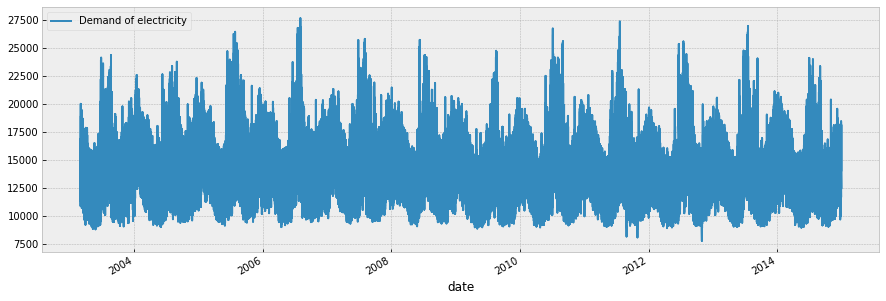

In [7]:
plt.style.use("bmh")
plt.figure(figsize=(15,5))
data.demand.plot(label='Demand of electricity')
plt.legend();

Seems like no increasing or decreasing trends

In [8]:
list(data.columns)

['year', 'month', 'day', 'weekday', 'hour', 'demand', 'temperature']

Visualizing demand by year, month, weekday, day, hour

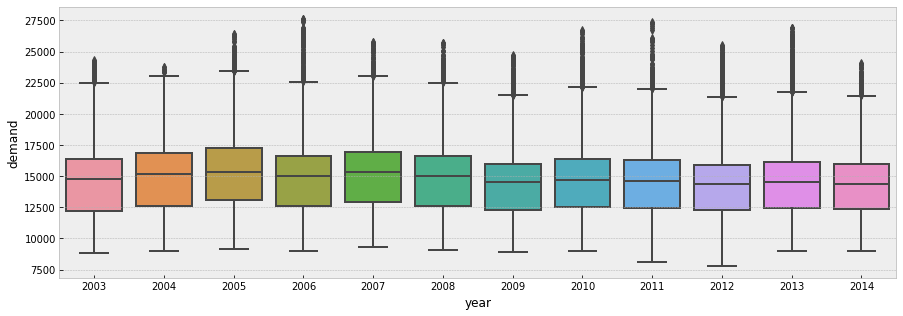

In [9]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data, x='year', y='demand');

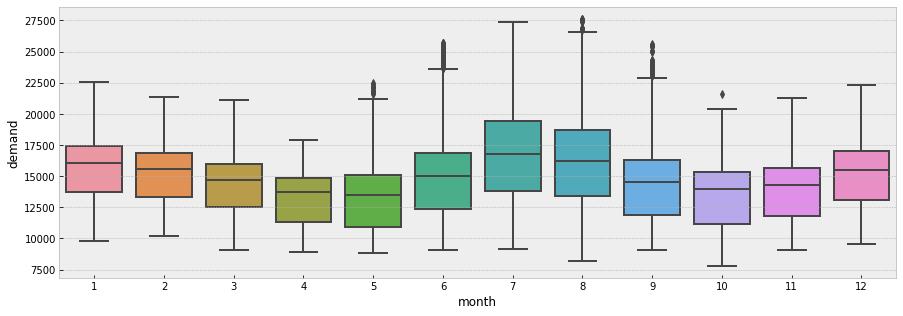

In [10]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data, x='month', y='demand');

July/August months shows higher demand for electricity

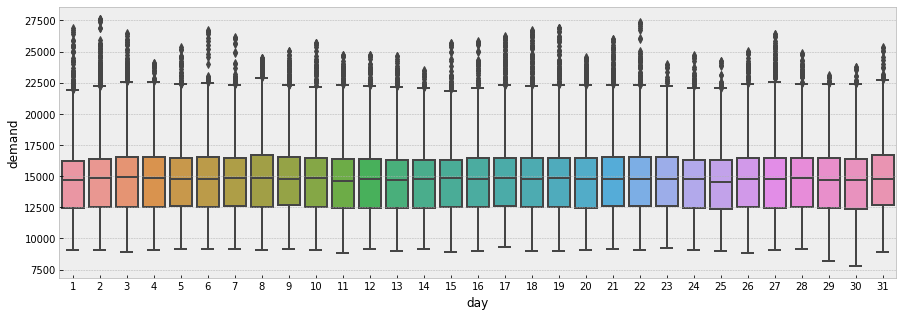

In [11]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data, x='day', y='demand');

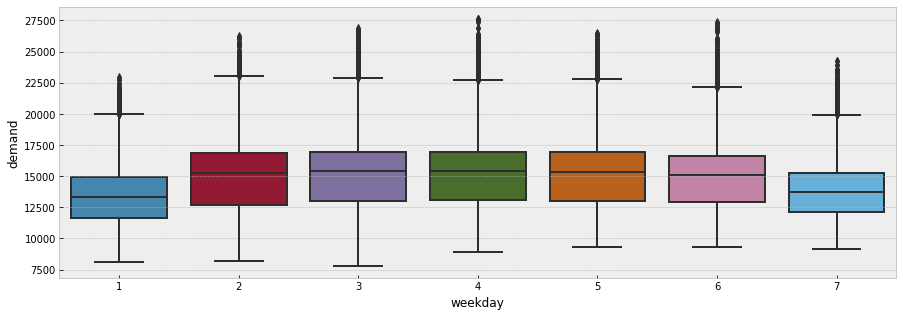

In [12]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data, x='weekday', y='demand');

Weekends have lower demand compared to weekdays

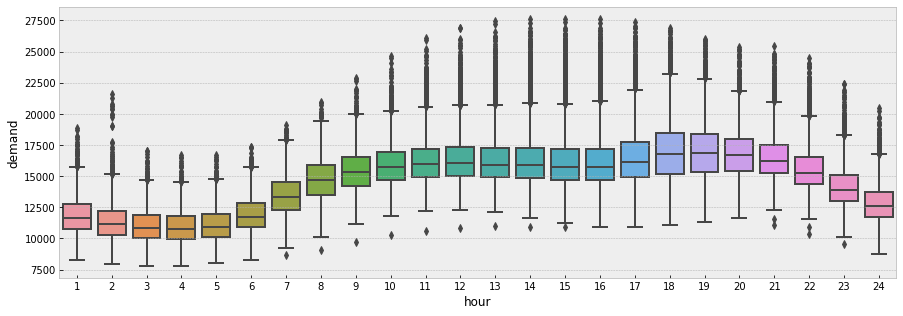

In [13]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data, x='hour', y='demand');

## Data Preprocessing

For modelling with DARTS, you need a time series object. TimeSeries class of DARTS helps us do that.

In [14]:
#Resampling demand at daily level
daily_demand = pd.DataFrame(data[['demand']].resample('D', origin = 'start').sum())
# daily_demand.reset_index(inplace=True)
daily_demand.head()

,demand
date,
2003-03-01,341205.0
2003-03-02,332439.0
2003-03-03,392373.0
2003-03-04,397812.0
2003-03-05,369405.0


In [15]:
#Creating timeseries object for demand
from darts import TimeSeries
series_demand = TimeSeries.from_dataframe(daily_demand, value_cols='demand')
series_demand

<TimeSeries (DataArray) (date: 4324, component: 1, sample: 1)>
array([[[341205.]],

       [[332439.]],

       [[392373.]],

       ...,

       [[343975.]],

       [[366625.]],

       [[368451.]]])
Coordinates:
  * date       (date) datetime64[ns] 2003-03-01 2003-03-02 ... 2014-12-31
  * component  (component) object 'demand'
Dimensions without coordinates: sample

## Model Training

seasonal? True
There is seasonality of order 7.


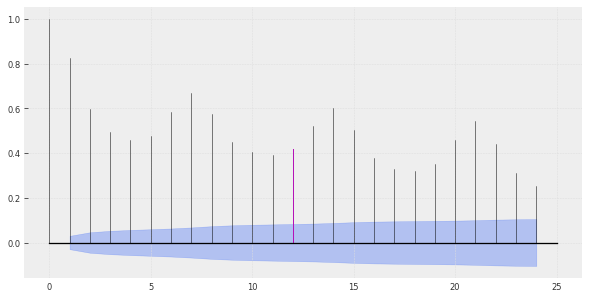

In [16]:
# Check for seasonality
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series_demand, m=m, alpha=0.05)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

plot_acf(series_demand, m=12, alpha=0.05)

Creating Train & Validation series

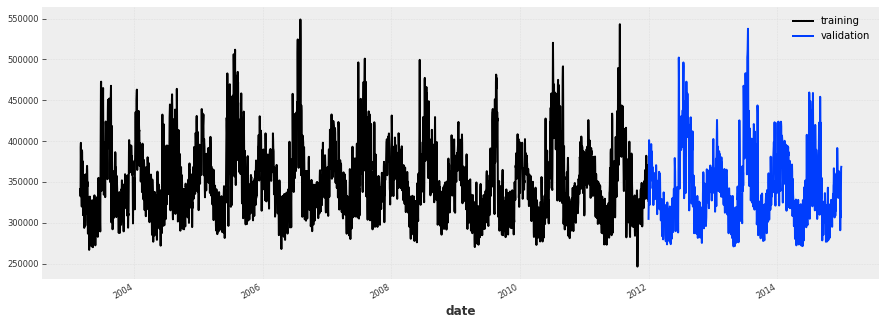

In [17]:
train, val = series_demand.split_before(pd.Timestamp("20120101"))
plt.figure(figsize=(15,5))
train.plot(label="training")
val.plot(label="validation")

Training some models and validating

In [18]:
from darts.models import ExponentialSmoothing, FFT, Prophet, AutoARIMA, Theta
from darts.metrics import mape, r2_score

def eval_model(model):
    start_time = datetime.now() 
    model.fit(train)
    time_elapsed = datetime.now() - start_time
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}% , Training time: {}".format(model, mape(val, forecast), time_elapsed))

eval_model(ExponentialSmoothing())
eval_model(FFT())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7 obtains MAPE: 137.17% , Training time: 0:00:00.545966
model FFT(nr_freqs_to_keep=10, trend=None) obtains MAPE: 11.33% , Training time: 0:00:00.015922
model Prophet obtains MAPE: 5.34% , Training time: 0:00:02.816466
model Auto-ARIMA obtains MAPE: 9.01% , Training time: 0:01:19.708806
model Theta(2) obtains MAPE: 8.94% , Training time: 0:00:00.019810


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


Based on error metric, Prophet is the best model for our current use case

In [19]:
model_demand = Prophet()
model_demand.fit(train)

Text(0.5, 1.0, 'MAPE: 5.3374659242936575')

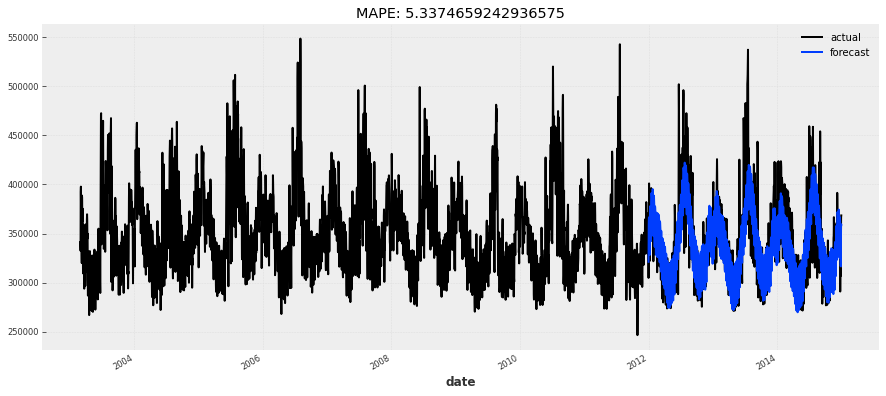

In [20]:
# use the model to make a forecast
pred_demand = model_demand.predict(len(val))

plt.figure(figsize=(15, 6))
series_demand.plot(label="actual")
pred_demand.plot(label="forecast")
plt.title("MAPE: {}".format(mape(val, pred_demand)))

Backtesting with some historical data

  0%|          | 0/19 [00:00<?, ?it/s]

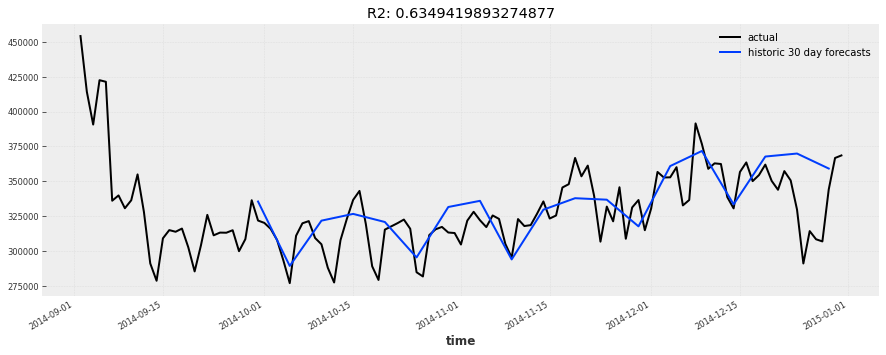

In [21]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(15, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

pred_series = model_demand.historical_forecasts(
    series_demand,
    start=pd.Timestamp("20140901"),
    forecast_horizon=30,
    stride=5,
    verbose=True,
)
display_forecast(pred_series, series_demand, "30 day", start_date=pd.Timestamp("20140901"))

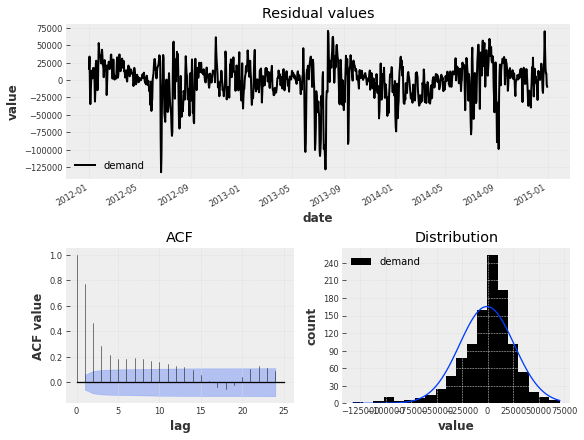

In [22]:
# investigate the residuals in the validation dataset
from darts.utils.statistics import plot_residuals_analysis
resid = pred_demand - val
plot_residuals_analysis(resid);

## Retraining using Temperature as a Covariate

In [23]:
#Resampling temperature at daily level
daily_temp = pd.DataFrame(data[['temperature']].resample('D', origin = 'start').mean())
daily_temp.head()

,temperature
date,
2003-03-01,32.083333
2003-03-02,34.458333
2003-03-03,14.958333
2003-03-04,18.791667
2003-03-05,36.458333


In [24]:
#Creating timeseries object for temperature
from darts import TimeSeries
series_temp = TimeSeries.from_dataframe(daily_temp, value_cols='temperature')
series_temp

<TimeSeries (DataArray) (date: 4324, component: 1, sample: 1)>
array([[[32.08333333]],

       [[34.45833333]],

       [[14.95833333]],

       ...,

       [[34.125     ]],

       [[23.5       ]],

       [[21.29166667]]])
Coordinates:
  * date       (date) datetime64[ns] 2003-03-01 2003-03-02 ... 2014-12-31
  * component  (component) object 'temperature'
Dimensions without coordinates: sample

Prophet's fit() only supports future covariates

In [25]:
model_future_covs = Prophet()
model_future_covs.fit(train, future_covariates=series_temp)

Text(0.5, 1.0, 'MAPE: 5.499367380745243')

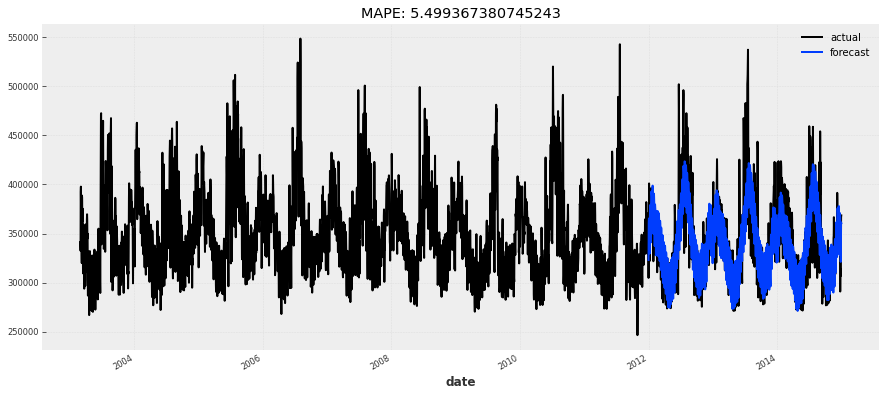

In [26]:
# use the model to make a forecast
pred_demand_covs = model_future_covs.predict(len(val), future_covariates=series_temp)

plt.figure(figsize=(15, 6))
series_demand.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title("MAPE: {}".format(mape(val, pred_demand_covs)))

This means temperature data is not improving the forecast.

  0%|          | 0/19 [00:00<?, ?it/s]

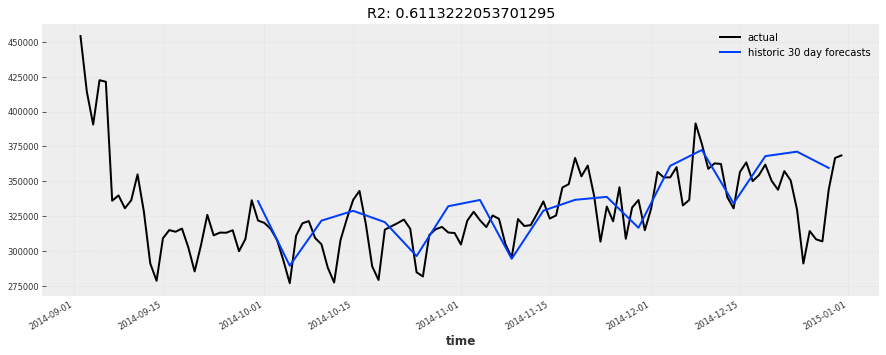

In [27]:
pred_series = model_demand.historical_forecasts(
    series_demand,
    start=pd.Timestamp("20140901"),
    forecast_horizon=30,
    stride=5,
    verbose=True, future_covariates=series_temp
)
display_forecast(pred_series, series_demand, "30 day", start_date=pd.Timestamp("20140901"))

The above was a quick attempt at forecasting using DARTS. I would try to use some regression, deep learning & ensemble models in future. Happy to have your feedback on the above!